In [ ]:
%load_ext autoreload
%autoreload 1
%aimport algorithms.your_algorithm

In [4]:
import os
import numpy as np 
import torch

%matplotlib inline
# %matplotlib ipympl
import matplotlib.pyplot as plt

from ML4CE_RL_environment import MESCEnv
from utils import plot_reward_evolution, plot_reward_distribution

from algorithms.reinforce import REINFORCE_alg
from algorithms.simulated_annealing import simulated_annealing_alg
from algorithms.heuristic_policy import HeuristicPolicy
from algorithms.your_algorithm import your_optimization_alg

# **1. Environment definition**

The goal of this coursework is to learn an inventory policy that provides the optimal way of placing orders, that is, the one that maximizes episodic returns. The policy model should therefore inform the decision-maker about when to place a replenishment order and the quantity to order so that customers' demand is satisfied.

Inventory optimisaiton is a sequential decision-making problem by nature. Thus, it can be modeled as a Markov Decision Process (MDP), which is the backbone of Reinforcement Learning (RL). The environment [MSCEnv](./IMP_CW_env.py) implements the underlying mathematical model to represent multi-echelon supply chains. This coursework deals with the three-echelon supply chain depicted below.

<p align="center">
  <img src=".\SCstructure.png" alt="SupplyChainStructure" width="500"/>
</p>

In this environment, **actions** represent the **order quantity** placed by each stage of the supply chain at each time step and the **observation space** provides information about the current **inventory position** at each stage of the supply chain. In addition, the state also encodes the day of the week since customers'demand is modelled as a Poisson random variable whose average number of events ($\lambda$) varies from weekdays to weekends.

\begin{equation*}
    \lambda = 
    \begin{cases}
        5 & \text{Mo-Fri}\\
        7 & \text{Sat-Sun} 
    \end{cases}  
\end{equation*}

Finally, the **reward** is defined as the **profit** obtained by the entire supply chain after each period: 
```python
reward = revenue - holding cost - fixed order cost - var order cost - penalty unsatisfied demand - penalty capacity violation
``` 

### **Basic usage**

Initialize the environment.

In [5]:
n_retailers = 2
n_DCs = 1
n_suppliers = 1
supply_chain_structure = [[n_retailers] , [n_DCs], n_suppliers]
time_horizon = 4*7 # = 28 days 

env = MESCEnv(supply_chain_structure, num_periods = time_horizon)

Interact with the environment.

In [6]:
# Get current observation of the state
current_state = env.state

# Sample a random action
random_action = env.action_space.sample()

# Take action, observe reward, and move to the next state
next_state , reward , episode_done , additional_info = env.step(random_action)
print("Environment status after taking a step:")
print(f"    Period {env.current_period}\n    Random action: {random_action}\n    Next state: {next_state}\n    Reward: {reward}")

# Reset the environment (take conditions back to day 1)
env.reset()
print("\nEnvironment status after reset:")
print(f"    Period {env.current_period}\n    Current state: {env.state}")

Environment status after taking a step:
    Period 2
    Random action: [ 46  20 136]
    Next state: [ 68  38 170   1]
    Reward: 101.0

Environment status after reset:
    Period 1
    Current state: [ 25  25 100   0]


# **2. Policy Optimization**
[comment]: <> (MLPregresor from sklearn is not used because you cannot specify input and output shapes prior to calling the fit method. Since in the ES approach it won't be used, we build NN using Pytorch.)

To optimise an inventory policy, different methods can be used. 
- **Heuristic methods** that rely on classic inventory control policies, like the (s,S) policy
- **Meta-heuristic algorithms** that iteratively explore the search space by mimiking natural phenomena, like simulated annealing (SA) or particle-swarm optimisation (PSO).
- **RL-specific algorithms**, such as Q-learning or REINFORCE.

Here, the policiy will be modelled as a multi-layer perceptron (MLP), as shown below. Note that you are not allowed to modify the network architecture, since the goal is that any improvement in the overall results should be only attributed to the performance of the optimization algorithm.

```python
class PolicyNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, h1_size = 128, h2_size = 64,):
        super(PolicyNetwork, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, h1_size)
        self.fc2 = torch.nn.Linear(h1_size, h2_size)
        self.fc3 = torch.nn.Linear(h2_size, output_size)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return x 
```

Therefore, your task consists in implementing a policy-based algorithm capable of solving the proposed Inventory Optimization problem. In the following sections, two basic implementations of Simulated Annealing and REINFORCE algorithms are introduced for illustration purposes.

## **2.1 Simulated Annealing**
Simulated Annealing (SA) is a simple optimization technique inspired by the thermodynamic process of cooling metal. The algorithm iteratively explores the feasible region, accepting better solutions and, at times, worse solutions based on a probability function driven by temperature. Over time, the "temperature" decreases, reducing the likelihood of accepting worse solutions. 

You can find more information about it [here](https://www.baeldung.com/cs/simulated-annealing), but the basic flowchart is shown below.
<figure>
<p align="center">
<img src="https://www.baeldung.com/wp-content/uploads/sites/4/2023/03/flowchart.png" width="500"/>
</p>
<!-- <figcaption align = "center"> Source: Sutton, R., & Barto, A. (2018). Reinforcement learning: an introduction. MIT Press. </figcaption> -->
</figure>

### **Implementation**

The function `simulated_annealing_alg` contains the code to run SA algorithm and can be found in the file [`simulated_annealing.py`](.\algorithms\simulated_annealing.py) under the folder **algorithms**. It returns two outputs:
* `save_path`: directory where the model weights of the optimal policy are saved in.
* `plot_data`: data used for plot generation and visualization of the training process.

By running the cell below, your SA algorithm will be executed using the hyperparameter configuration you defined in the dict `hyperparamSA`.

In [5]:
hyperparamSA = {}
# Problem specs 
hyperparamSA['param_min'] = -1.
hyperparamSA['param_max'] = 1.
hyperparamSA['num_episodes_avg'] = 5
# Algorithm-specific hyperparameters
hyperparamSA['initial_temp'] = 1e7
hyperparamSA['max_episodes'] = 200
# Execution control
hyperparamSA["max_time"] = 60

Run training with the desired hyperparameter configuration.

**NOTE:** as the performance of the algorithm is **very sensitive to parameter initialization**, results might differ across consecutive runs with the same configuration.

In [6]:
policySA_model_path , plot_info = simulated_annealing_alg(env, **hyperparamSA)

Iteration loop: 100%|██████████| 40/40 [00:07<00:00,  5.58it/s]

Policy model weights saved in: SA_policies//SA_policy_1.pt
Best reward found during training: 9403.619397203904


### **Training analysis:** plot reward evolution during training.

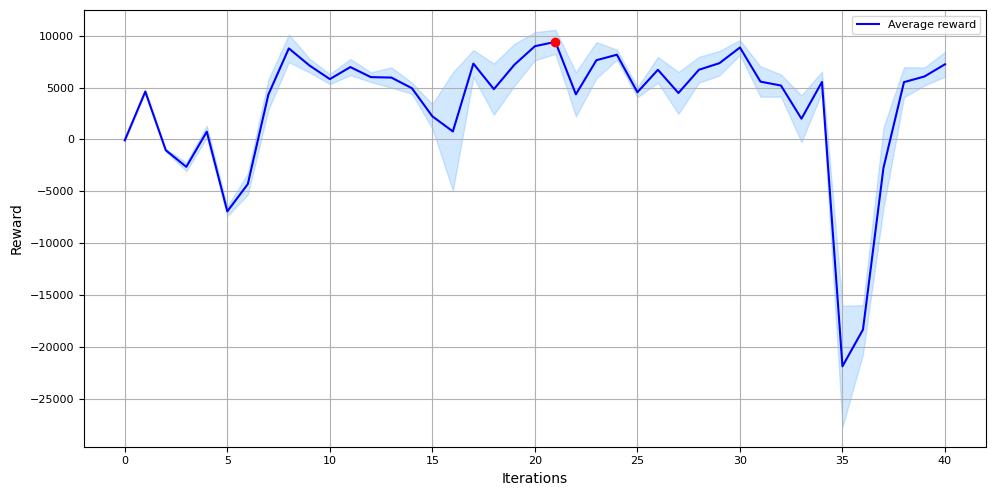

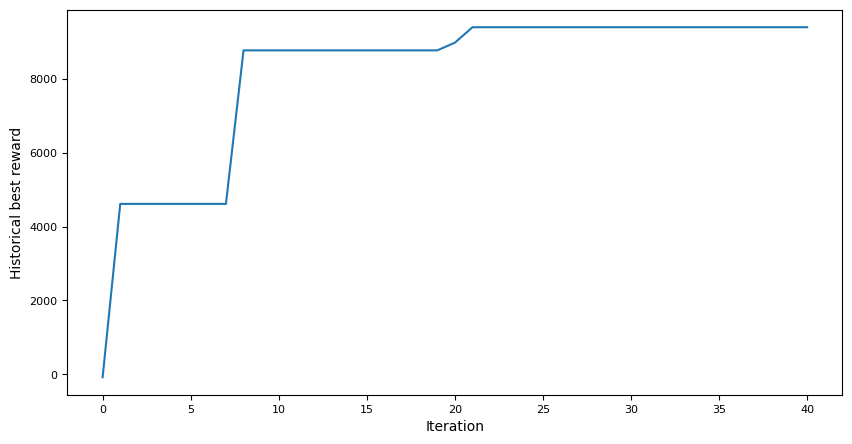

In [7]:
# Plot solution evolution per iteration
plot_reward_evolution(list(range(len(plot_info['reward_history']))), plot_info['reward_history'], reward_std=plot_info['std_history']);

# Plot historical best reward
plt.plot(list(range(len(plot_info['best_reward_history']))), plot_info['best_reward_history'])
plt.xlabel('Iteration')
plt.ylabel('Historical best reward');

## **2.2 REINFORCE with baseline**

REINFORCE is a foundational RL algorithm belonging to the familiy of policy-based methods. REINFORCE updates the probability of taking specific actions in certain states based on how much those actions contributed to higher overall rewards in past episodes. The policy being learned is the same policy used to generate the data the agent uses to learn, hence it follows an "on-policy" approach.

<figure>
<p align="center">
<img src="https://lcalem.github.io/imgs/sutton/reinforce_baseline.png" width="800"/>
</p>
<figcaption align = "center"> Source: Sutton, R., & Barto, A. (2018). Reinforcement learning: an introduction. MIT Press. </figcaption>
</figure>

### **Implementation**

As in the previous example, the function `REINFORCE_alg`, found in the file [`reinforce.py`](.\algorithms\reinforce.py), implements an improved variation of REINFORCE method: REINFORCE with baseline.

Again, this function outputs:
* `save_path`: directory where the model weights of the optimal policy are saved in.
* `plot_data`: location where data used for visualization purposes is stored.

Before executing the algorithm, the desired hyperparameter configuration can be defined as a dict object in `hyperparamRL`.

In [7]:
hyperparamRL = {}
hyperparamRL["max_episodes"] = 200 

Run training with the desired hyperparameter configuration. 

**NOTE:** as the performance of the algorithm is **very sensitive to parameter initialization**, results might differ across consecutive runs with the same configuration.

In [8]:
policyRL_model_path , plot_info = REINFORCE_alg(env, **hyperparamRL)

Episode loop: 100%|██████████| 200/200 [00:22<00:00,  8.76it/s]


Policy model weights saved in: REINFORCE_policies//REINFORCE_policy_8.pt
Best reward: 5970.0


### **Training analysis:** plot reward evolution during training

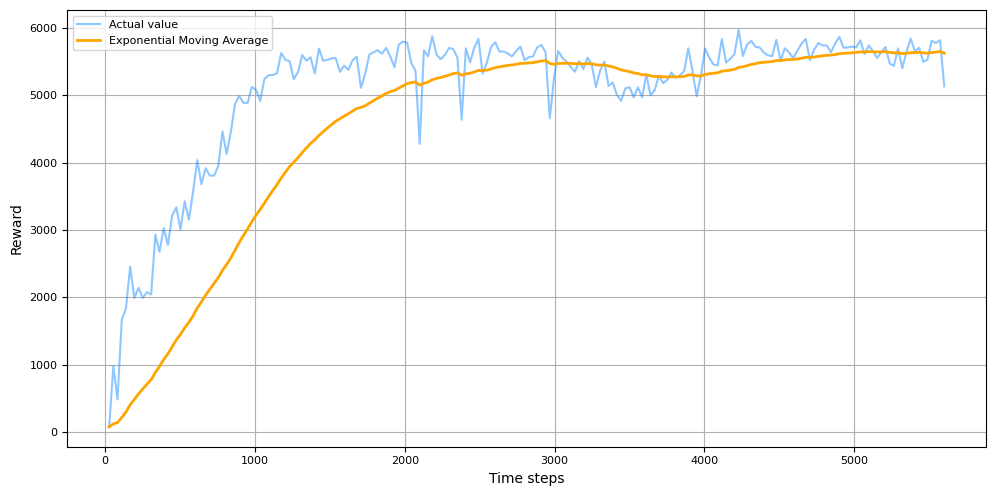

In [9]:
plot_reward_evolution(plot_info['timesteps'], plot_info['reward_history'])

## **2.3 Your algorithm**

It is your turn to develop your own optimization algorithm, either by modifying the code provided as reference or coding your own algorithm from scratch. As a suggestion, some improvements needed by the existing code are: 
* Tuning default values of hyperparameters 
* More advanced features (e.g., learning rate decay)

Please, use the file [your_algorithm.py](.\algorithms\your_algorithm.py), which you can find in the `algorithms` folder, to implement your code. 

To ensure compliance with our testing platform, it is vital to **respect the structure and signatures of the template** and limit the use of Python packages to `numpy` and `torch`.

Note that we will test your implementation on a different environment and with a **limited budget**. For grading purposes, `max_episodes` and `max_time` will be limited to 200 episodes and 60 s, respectively. 

In addition, your algorithm will be run **multiple times with different seeds** to mitigate the effect of random initialization when obtaining the final score.

#### Hyperparameter definition

In [ ]:
hyperparam = {}
hyperparam['max_episodes'] = 20
hyperparam['max_time'] = 60 # seconds

#### Model training

In [ ]:
save_path, plot_info = your_optimization_alg(env, hyperparam**)

#### Training analysis

In [ ]:
plot_reward_evolution(plot_info['timesteps'], plot_info['reward_history'])

# **3. Policy evaluation**
### **3.1. Test data**: get new demand scenarios
The variable test_demand_dataset contains 100 samples of demand scenarios, with 4 weeks each, that will be used for testing and comparing the extrapolation capabilities of the different policies.

In [7]:
import pickle
# Open the file in binary mode
path = os.path.join("benchmarking", "test_demand_dataset.pickle")
with open(path, 'rb') as file:
    # Deserialize and retrieve the variable from the file
    test_demand_dataset = pickle.load(file)

### **3.2. Evaluation**
To assess the performance of each algorithm, the optimal policies are evaluated on the test dataset and the average undiscounted return is computed.

Please, execute the following cells to test the performance of your optimization algorithm.

In [9]:
from common import PolicyNetwork, evaluate_policy

policy = PolicyNetwork(input_size=env.observation_space.shape[0], 
                       output_size=env.action_space.shape[0],
                       )

results = {}

In [ ]:
# -----------------------------------------------------------------------
# Change path to the one pointing to the model you want to evaluate
# -----------------------------------------------------------------------
path = r".\your_policies\optimal_policy_0.pt" 
# -----------------------------------------------------------------------

policy.load_state_dict(torch.load(path))
results["Your algorithm"] = evaluate_policy(policy, env, test_demand_dataset )

print(f"Performance of your optimization algorithm:\n - Average reward: {np.mean(results["Your algorithm"]):.2E}\n - Reward standard deviation: {np.std(results["Your algorithm"]):.2E}")


Next, the same process is repeated with different benchmarking policies, which have been evaluated using the same `test_demand_dataset`. 

The policies considered for benchmarking are:
* A neural network whose weights have been optimized using the algorithm **Simulated Annealing**.
* A neural network whose weights have been optimized using a **REINFORCE with baseline** algorithm.
* An **(s,S) policy**, which is a simple heuristic strategy where an order is placed to bring the inventory up to a target maximum level *S* only when the on-hand inventory, or inventory position, falls to or below a reorder point *s*.

In [10]:
for alg in ['SA','REINFORCE_with_baseline']:
    path = r".\benchmarking\policy_"+ alg + ".pt"
    policy.load_state_dict(torch.load(path))
    results[alg] = evaluate_policy(policy, env, test_demand_dataset )
    print(f"{alg} performance:\n - Average reward: {np.mean(results[alg]):.2E}\n - Reward standard deviation: {np.std(results[alg]):.2E}")

sSpolicy = HeuristicPolicy()
sSpolicy.policy_param = np.array([11., 30., 20., 34., 61., 76.])
results["sS"] = sSpolicy.evaluate_policy(env, test_demand_dataset)
print("(s,S) policy performance:\n - Average reward: {:.2E}\n - Reward standard deviation: {:.2E}".format(np.mean(results["sS"]), np.std(results["sS"])))

SA performance:
 - Average reward: 7.53E+03
 - Reward standard deviation: 1.38E+03
REINFORCE_with_baseline performance:
 - Average reward: 5.58E+03
 - Reward standard deviation: 9.55E+01
(s,S) policy performance:
 - Average reward: 1.12E+04
 - Reward standard deviation: 8.69E+02


### **3.3 Result analysis:** reward distribution
Plot the distribution of rewards and compare your results to those obtained with other benchmarking poilicies.

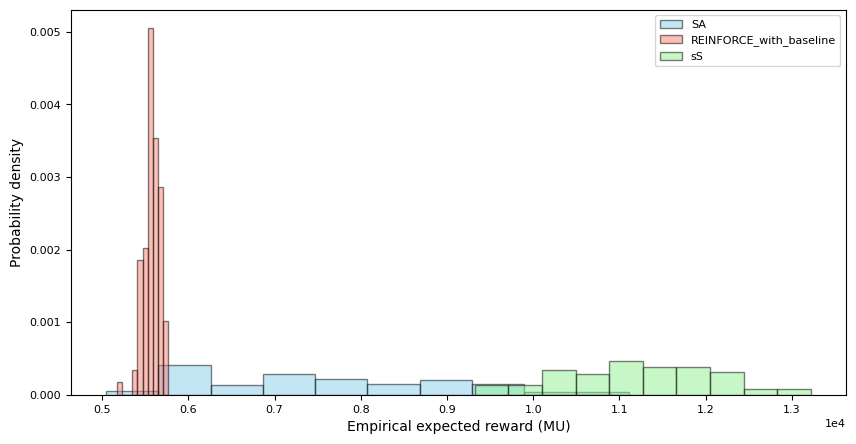

In [11]:
plot_reward_distribution(np.vstack([results[alg] for alg in results.keys()]).T, labels=results.keys())